# FoReS (Foundation Recommender System)
A recommender system for people that are new to the world of foundations and don't know where to start. Basically it recommends you a foundation shades based on your skin tone using Fitzpatrick scale.

In [5]:
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


## Import the necessary package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pycocotools import mask as maskUtils
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
using_colab = False

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib torch torchvision
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Data Exploration Analysis

In [5]:
# Count the number of train and val images
train_data = pd.read_csv('datasets/fitzpatrick/train.csv')
test_data = pd.read_csv('datasets/fitzpatrick/test.csv')
train_images = len(os.listdir("datasets/fitzpatrick/fairface/train/"))
test_images = len(os.listdir("datasets/fitzpatrick/fairface/val/"))

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Train images: {train_images}")
print(f"Test images: {test_images}")

Train data: 35424
Test data: 4515
Train images: 35445
Test images: 4535


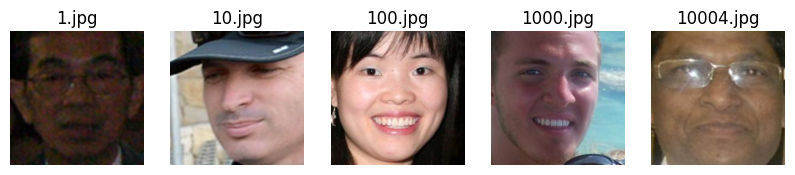

In [6]:
# Display 5 images from train folder
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = cv2.imread(f"datasets/fitzpatrick/fairface/train/{train_data.iloc[i]['file']}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(train_data.iloc[i]['file'].split('/')[0])
    plt.axis('off')
plt.show()

## Images Preprocessing

In [7]:
df_train = pd.read_csv('datasets/fitzpatrick/train.csv')
df_test = pd.read_csv('datasets/fitzpatrick/test.csv')

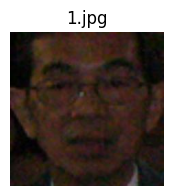

In [8]:
# Read all the images from the train.csv file
file_paths_train = df_train['file'].apply(lambda x: f"datasets/fitzpatrick/fairface/train/{x}").values
train_images = np.array([cv2.imread(file_path) for file_path in file_paths_train])

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_BGR2RGB))
plt.title(df_train.iloc[0]['file'].split('/')[0])
plt.axis('off')
plt.show()

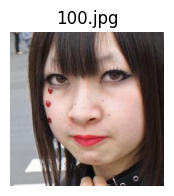

In [9]:
# Read all the images from the test.csv file
file_paths_test = df_test['file'].apply(lambda x: f"datasets/fitzpatrick/fairface/val/{x}").values
test_images = np.array([cv2.imread(file_path) for file_path in file_paths_test])

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_BGR2RGB))
plt.title(df_test.iloc[0]['file'].split('/')[0])
plt.axis('off')
plt.show()

### Zoom & Center the Image

In [27]:
def zoom_center(img, zoom_factor=2):
    x_width = img.shape[1]
    y_height = img.shape[0]

    x1 = int(0.5 * x_width * (1 - 1 / zoom_factor))
    y1 = int(0.5 * y_height * (1 - 1 / zoom_factor))

    x2 = int(x_width - 0.5 * x_width * (1 - 1 / zoom_factor))
    y2 = int(y_height - 0.5 * y_height * (1 - 1 / zoom_factor))
    
    # Crop then scale
    cropped_img = img[y1:y2, x1:x2]
    return cv2.resize(cropped_img, None, fx=zoom_factor, fy=zoom_factor)

In [39]:
def display_image(img, title=None):
    plt.figure(figsize=(3, 3))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

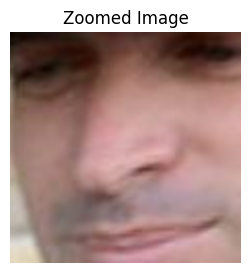

In [40]:
new_img = zoom_center(train_images[1], 2)
display_image(new_img, "Zoomed Image")